In [311]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

#plt.style.use("seaborn")
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = (14.0, 10.0) # set default size of plots
# good behavior for notebooks!
sns.set(context='notebook' , color_codes=True)
%matplotlib inline

# Finding Higgs Bosons!!

This notebook will serve as a building block for homework set four, in which you'll be exploring the use of Neural Networks (NNs) to study a represenative data sample from the search for the Higgs boson at the Large Hadron Collider (LHC).  In 2014, a machine learning challenge was posted to Kaggle to encourage data scientists across the world to try their hand(s) at searching for Higgs bosons in a simulated data sample.  The simulations were identical to the ones used by the ATLAS collaboration to search for Higgs bosons decaying to two tau leptons ($H \rightarrow \tau^+ \tau^-$).

Many people tried their best and after 6 months the contest ended.  Three winners were chosen by the contest judges and were awarded cash prizes, as well as an expense-paid trip to CERN:

1.  Gabor Melis : 7000 dollars
2.  Tim Salimans : 4000 dollars
3.  Pierre Courtiol (nhlx5haze) : 2000 dollars

You can find details about the challenge at the primary ATLAS site (https://higgsml.lal.in2p3.fr) and on Kaggle (https://www.kaggle.com/c/higgs-boson/).  The data sample consists of over 800k "events" that are a mixture of simulated $H \rightarrow \tau^+ \tau^-$ signal events with $M_{Higgs}=125$ GeV in addition to a range of non-Higgs "background" events (eg, $Z \rightarrow \tau^+ \tau^-$).  In this context, one event corresponds to a proton-proton collision at the LHC that was recorded by the ATLAS detector.  The signal-to-background ratio is roughly 0.0017, so the challenge is much like searching for a needle in a haystack! 

The data sample consists of 17 "primitive / PRI" features that correspond to the reconstructed observables in each event and 13 "derived / DER" features that are constructed from the primitive features using domain knowledge of the signal and background processes.  In addition, the are unique identifiers (Event ID) and sample weights that allow for converting from integer simulated events to the expected number of events to have been produced in the data sample.  A detailed description of the features is provided here (http://opendata.cern.ch/record/328) and in even more detail here (http://opendata.cern.ch/record/329).  You are not expected to spend time learning the details, so this is for your own interest.

The contestants were given the first 250k events with labels ("s" and "b") to allow for training of a supervised learning classifier.  In addition, a second sample of 250k events **without** labels was provided as a way of testing for overtraining.  A third sample of ~300k events was withheld by the contest organizers as a blind validation sample to rank the contestants.  The ranking was performed by evaluating a metric called the "Approximate Median Significance", wherein a larger value corresponds to a more significant observation of Higgs boson production.  The submissions at the top of the leaderboards had AMS scores around 3.80.

$AMS  = \sqrt{2\left( (s+b+10)\log\left(1+{s \over b+10}\right) -s \right)}$


Your challenge in homework set four will be to engage in the Higgs boson ML contest for yourself as a way to learn about NNs.  We will use this data set for class sessions on Feb 23, Feb 25 and Mar 4.  In this notebook, we will explore the use of the Multilayer Perceptron classifier offered by `scikit-learn`.  In the following class periods, we will explore the use of `PyTorch` and `Keras` as alternative NN frameworks.

# Load the data sample

The first thing to do here is load the data sample.  We will use the `pandas` `dataframe` class, as it's well suited to this task.  For the training sample, we will use the first 350k samples.  The remaining samples will be for validation and evaluation of independent AMS scores.

In [306]:
# read the first 350k samples
dataset=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',nrows=350000)

# summarize the data

# shape
print("Shape:\n",dataset.shape, "\n")

# first 20 samples
#print("Head:\n",dataset.head(20), "\n")

# descriptions
#print("Description:\n",dataset.describe(), "\n")

# class distributio
#print("Class Distribution:\n",dataset.groupby('Label').size())


Shape:
 (350000, 35) 



# Now groom the data sample

We need prepare a subset of the sample on which to train.  We will remove all of the variables that should not be used in the training and retain the rest.  In addition, we'll keep a copy of the labels and weights for later.

In [307]:
# Make a new dataframe without some of the features
X = dataset.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weights = dataset['Weight'].values

# We'll find it useful to have the dataframe column names
colNames = X.columns

# Two forms of the 
y = pd.get_dummies(dataset.Label)
yt = y.values[:,0]

# Build selectors to separate our data in to signal and background
sSelector = np.array(yt == 0)
bSelector = np.array(yt == 1)

# Calculate what's in our samples
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

nweights = np.copy(weights)
nweights[sSelector] *= sumBWeights/sumSWeights

sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])
print("Total Events: {}, Signal: {}, Background: {}".format(sumWeights,sumSWeights,sumBWeights))

# Perform standard scaling!
#scaler = StandardScaler()  
# Don't cheat - fit only on training data
#scaler.fit(X.values)  
#Xplot = scaler.transform(X.values)  

print(Xplot.shape)

Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966
Total Events: 175886.38646959182, Signal: 297.4593763421059, Background: 175588.92709324966
(350000, 30)


# Make some figures!

Next let's make figures of the different variables in the data sample.  There are 30 features available, of varying levels of discrimination between signal and background classes.

In [308]:
def getRange(sig, bkg):
    ret = np.zeros(2)
    amin = np.min(sig)
    ret[0] = amin
    if amin <-998:
        ret[0] = 0
    vals, bins = np.histogram(sig,bins=100)
    vals2, bins2 = np.histogram(bkg,bins=100)

    ret[1] = np.maximum(np.max(sig),np.max(bkg))

    idx = 0
    for val in vals:
        if val > 2:
            ret[1] = bins[idx+1]
        if vals2[idx] > 2:
            ret[1] = bins2[idx+1]
        idx += 1
        
    if ret[1] < ret[0]:
        ret[1] = np.maximum(np.max(sig),np.max(bkg))
    
    if np.abs(1.0-ret[1])<0.1:
        ret[1] = 1.0
    
    return ret

def plotHisto(sig,bkg,label,ax, doNorm=True, s_weight=None, b_weight=None):
    trange = getRange(sig,bkg)
    
    sweight = None
    bweight = None
    if doNorm == True:
        sweight = s_weight
        bweight = b_weight
    
    sVals, edges = np.histogram(sig,bins=100,range=trange,weights=sweight)
    bVals, edges = np.histogram(bkg,bins=100,range=trange,weights=bweight)
    xvals = np.linspace(trange[0],trange[1],100)
    
    if doNorm:
        ax.plot(xvals,sVals/np.sum(sVals),label="Signal")
        ax.plot(xvals,bVals/np.sum(bVals),label="Bkgd")
        ax.set_title("{}, Normalized".format(label))
    else:
        ax.plot(xvals,sVals,label="Signal")
        ax.plot(xvals,bVals,label="Bkgd")
        ax.set_title("{}, Unnormalized".format(label))
    ax.set_ylim(bottom=0)
    ax.legend()

def plotNNresults(predictions,sSelector,bSelector,weights):
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    plotHisto(predictions[sSelector,1],predictions[bSelector,1],"Neural Nework",
              axs[0],doNorm=False)
    plotHisto(predictions[sSelector,1],predictions[bSelector,1],"Neural Nework",
              axs[1],doNorm=True,b_weight=weights[bSelector],s_weight=weights[sSelector])
    plt.show()
    
#for idx in range(int(colNames.size / 2)):
#    idx2 = int(colNames.size / 2)+idx
#    
#    fig, axs = plt.subplots(1,2, figsize=(12,10))
#    plotHisto(Xplot[sSelector,idx],Xplot[bSelector,idx],colNames[idx],axs[0])
#    plotHisto(Xplot[sSelector,idx2],Xplot[bSelector,idx2],colNames[idx2],axs[1])

#    plt.show()

# Build a neural network

Our goal is to correctly classify signal and background events.  There are many ways to approach this, but for now we'll focus on neural networks.  For this exercise, we'll get started by using the Multilayer Perceptron class from `scikit-learn`.  This has become a very nice implementation that can create rather deep networks.  The major downside is that it does not have GPU or TPU support.

For our first step, let's consider that we have 30 features.  This is a relatively large space with many potential correlations, so we'll want to try for a relatively large network.  Let's start off by creating a network with two hidden layers with 30 nodes (neurons) and limit to 50 training cycles.  This will give us a first benchmark for our problem.

In [313]:
def trainModel(xTrain, yTrain, dim, sigWeight = 2, batches = 500, verbose=False, sweights=None):
    activate = "relu"

    model=Sequential()
    model.add(Input(dim))
    model.add(BatchNormalization())
    model.add(Dense(200,activation=activate,kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5)))
    model.add(Dropout(0.2))
#    model.add(BatchNormalization())
    model.add(Dense(30,activation=activate,kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1],activation="softmax"))

    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'] )
    print("Using signal weight = ",sigWeight)
    class_weight = {0: 1, 1: sigWeight}
    model.fit(xTrain,yTrain,validation_split=0.1,class_weight=class_weight,workers=4,use_multiprocessing=True,
              sample_weight=sweights, batch_size=batches,verbose=verbose,shuffle = True,epochs =100)
    
    return model

In [316]:
modelAll = trainModel(Xplot,y.values,X.shape[1],sigWeight=np.sum(yt==1)/np.sum(yt==0), 
                      sweights=nweights, verbose=True)


Using signal weight =  1.9177121801979042
Epoch 1/100
630/630 [==============================] - 4s 6ms/step - loss: 0.5784 - accuracy: 0.6510 - val_loss: 0.3767 - val_accuracy: 0.7084
Epoch 2/100
630/630 [==============================] - 1s 1ms/step - loss: 0.4784 - accuracy: 0.7090 - val_loss: 0.3670 - val_accuracy: 0.7197
Epoch 3/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4697 - accuracy: 0.7148 - val_loss: 0.3705 - val_accuracy: 0.7116
Epoch 4/100
630/630 [==============================] - 1s 1ms/step - loss: 0.4657 - accuracy: 0.7176 - val_loss: 0.3684 - val_accuracy: 0.7241
Epoch 5/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4614 - accuracy: 0.7173 - val_loss: 0.3637 - val_accuracy: 0.7291
Epoch 6/100
630/630 [==============================] - 1s 1ms/step - loss: 0.4594 - accuracy: 0.7212 - val_loss: 0.3668 - val_accuracy: 0.7182
Epoch 7/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4608 - accuracy: 0.7207

630/630 [==============================] - 1s 2ms/step - loss: 0.4392 - accuracy: 0.7371 - val_loss: 0.3592 - val_accuracy: 0.7326
Epoch 58/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4433 - accuracy: 0.7347 - val_loss: 0.3562 - val_accuracy: 0.7402
Epoch 59/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4423 - accuracy: 0.7386 - val_loss: 0.3556 - val_accuracy: 0.7305
Epoch 60/100
630/630 [==============================] - 1s 1ms/step - loss: 0.4474 - accuracy: 0.7318 - val_loss: 0.3595 - val_accuracy: 0.7358
Epoch 61/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4451 - accuracy: 0.7351 - val_loss: 0.3549 - val_accuracy: 0.7375
Epoch 62/100
630/630 [==============================] - 1s 2ms/step - loss: 0.4427 - accuracy: 0.7361 - val_loss: 0.3562 - val_accuracy: 0.7367
Epoch 63/100
630/630 [==============================] - 1s 1ms/step - loss: 0.4430 - accuracy: 0.7339 - val_loss: 0.3585 - val_accuracy: 0.7364
Epoch

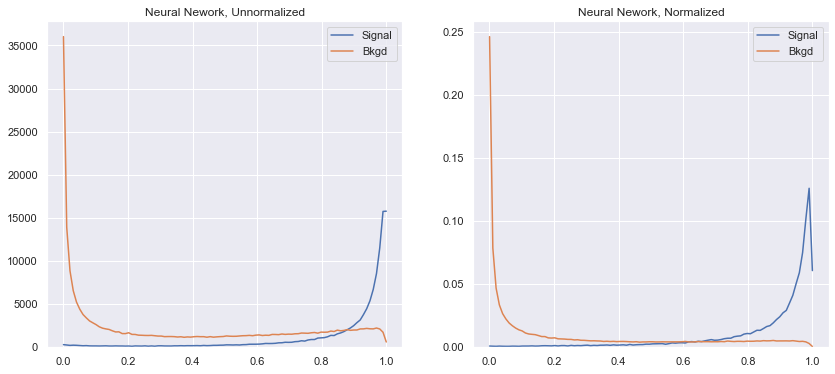

In [295]:
predictionsAll = modelAll.predict(Xplot)
plotNNresults(predictionsAll,sSelector,bSelector,weights) 

# Finally, let's check to see how we did for our challenge

The challenge was "judged" based on the Approximate Mean Significance (AMS) score.  Let's just quickly check how we did on our training data.  This is an over-estimate because we trained on this data, but it will give us an idea of how we did!  Remember the best work in the Higgs ML challenge achieved an AMS score of ~ 3.80.

In [296]:
def ams(s,b):
    from math import sqrt,log
    if b==0:
        return 0
    
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

def plotAMS(Xa,ya,wa,sel=None):
    yp = ya
    wp = wa
    if sel is not None:
        yp = ya[sel]
        wp = wa[sel]
        
    # order them 
    sSelector = np.array(yp == 0)
    bSelector = np.array(yp == 1)
    
    permute = Xa.argsort()
    sSelector = sSelector[permute]
    bSelector = bSelector[permute]
    Xa = Xa[permute]
    wp = wp[permute]

    # pick out only the signal values
    sVals = Xa[sSelector]
    sigW = wp[sSelector]

    # pick out only the background values
    bVals = Xa[bSelector]
    bkgW = wp[bSelector]

    # make arrays
    xvals = np.linspace(0,1,1000)
    amsV = np.linspace(0,1,1000)
    bkgFrac = np.linspace(0,1,1000)
    aIdx = 0

    # We are going to organize by background rejection fraction,
    # so we need to find those values
    for xx in xvals:
        idxS = bisect.bisect_left(sVals,xx)
        idxB = bisect.bisect_left(bVals,xx)
        amsV[aIdx] = ams(np.sum(sigW[idxS:]),np.sum(bkgW[idxB:]))
        bkgFrac[aIdx] = 1-np.sum(bkgW[idxB:])/np.sum(bkgW)
        aIdx += 1

    permute = bkgFrac.argsort()
    bkgFrac = bkgFrac[permute]
    amsV = amsV[permute]

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(bkgFrac*100,amsV)
    ax.set_xlabel("Background rejection (%)")
    ax.set_ylabel("AMS Score")
    plt.show()
    print("Maximum AMS Value: ",np.max(amsV))

In [297]:
# read the first last ~468k samples
datasetVal=pd.read_csv('higgs-boson/atlas-higgs-challenge-2014-v2.csv',skiprows = range(1, 350000))

# shape
print("Shape:\n",datasetVal.shape, "\n")

# Make a new dataframe without some of the features
Xval = datasetVal.drop([ 'Label','EventId','Weight','KaggleSet','KaggleWeight'],axis=1,inplace=False)
weightsVal = datasetVal['Weight'].values

# Perform standard scaling!
XplotV = scaler.transform(Xval.values)  

# Two forms of the labels
yv = pd.get_dummies(datasetVal.Label)
yVal = yv.values[:,0]

Shape:
 (468239, 35) 



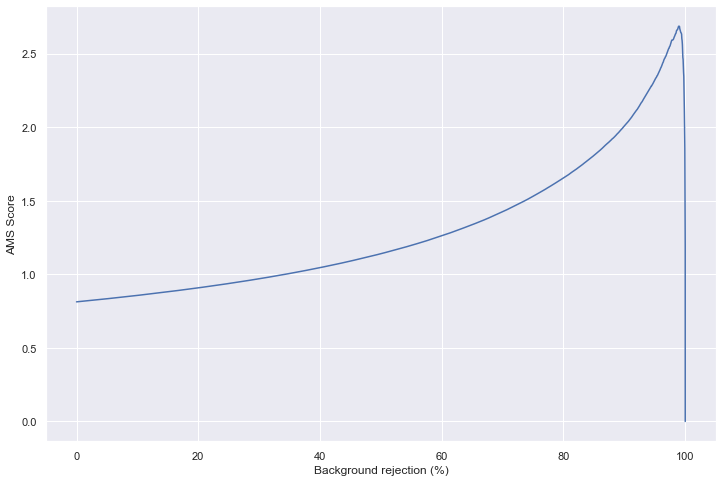

Maximum AMS Value:  2.6861720865106102


In [317]:
# Evaluate our new data with the NN
predictions = modelAll.predict(XplotV)
# Plot the AMS scores
plotAMS(predictions[:,1],yVal,weightsVal)